In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

#Source
#Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning. In Proceedings of the 2018 International Conference on Digital Health (DH '18). ACM, New York, NY, USA, 121-125. DOI: [Web Link]
# Any results you write to the current directory are saved as output.

# Import the libraries


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop, SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report


%matplotlib inline

Using TensorFlow backend.


# Read in data

In [3]:
Test_df = pd.read_csv('../input/drugLibTest_raw.csv')
Train_df = pd.read_csv('../input/drugLibTrain_raw.csv')
Data_df = pd.concat([Train_df, Test_df])

Data_df.dropna(inplace = True)

Data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4132 entries, 0 to 1035
Data columns (total 9 columns):
Unnamed: 0           4132 non-null int64
urlDrugName          4132 non-null object
rating               4132 non-null int64
effectiveness        4132 non-null object
sideEffects          4132 non-null object
condition            4132 non-null object
benefitsReview       4132 non-null object
sideEffectsReview    4132 non-null object
commentsReview       4132 non-null object
dtypes: int64(2), object(7)
memory usage: 322.8+ KB


## Rating to good/bad



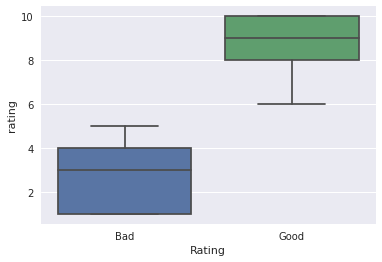

In [4]:
Data_df['Rating'] = pd.cut(Data_df['rating'], 2, labels = ['Bad', 'Good'])


sns.boxplot(x="Rating", y="rating", data=Data_df)
plt.show()

## Preprocess the text data


In [5]:
Data_df['commentsReview'] = Data_df['commentsReview'].apply(lambda x: x.lower())
Data_df['commentsReview'] = Data_df['commentsReview'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

# Drop unwanted columns


In [6]:
Data_df = Data_df[['Rating', 'commentsReview']]

Data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4132 entries, 0 to 1035
Data columns (total 2 columns):
Rating            4132 non-null category
commentsReview    4132 non-null object
dtypes: category(1), object(1)
memory usage: 228.7+ KB


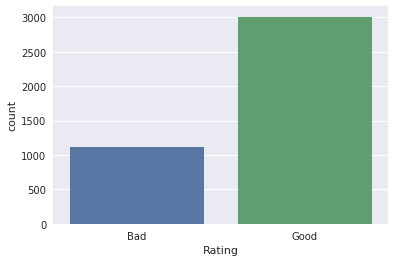

In [7]:
#Look at distribution
sns.countplot(x = 'Rating', data =Data_df)


In [8]:
print(Data_df['commentsReview'].str.split().str.len().mean())
print(Data_df['commentsReview'].str.split().str.len().max())

50.74515972894482
740


## Create vector with features and vector with encoded label


In [10]:
max_words = 2000
max_len = 500
#Tokenize the data
tok = Tokenizer(num_words=max_words, split = ' ')
tok.fit_on_texts(Data_df['commentsReview'].values)
#Convert to sequences
X = tok.texts_to_sequences(Data_df['commentsReview'].values)
#Ensure all sequences have same length
X = sequence.pad_sequences(X)


## Set up model


In [31]:
embedding_vecor_length = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_words,embedding_vecor_length,input_length=X.shape[1]))
model.add(LSTM(50))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 692, 128)          256000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 291,902
Trainable params: 291,902
Non-trainable params: 0
_________________________________________________________________


## Train/test split

In [13]:
Y = pd.get_dummies(Data_df['Rating']).values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.4,  stratify=Y, random_state = 2018)

X_train, X_val, Y_train, Y_val  = train_test_split(X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=2018)

## Fit on dataset


In [33]:
LSTM_model = model.fit(X_train,Y_train,batch_size=32,epochs=10,
          validation_data=(X_val, Y_val))

Train on 1983 samples, validate on 496 samples
Epoch 1/10
1983/1983 [==============================] - 44s 22ms/step - loss: 0.5944 - acc: 0.7252 - val_loss: 0.5690 - val_acc: 0.7278
Epoch 2/10
1983/1983 [==============================] - 43s 22ms/step - loss: 0.4885 - acc: 0.7640 - val_loss: 0.5757 - val_acc: 0.7339
Epoch 3/10
1983/1983 [==============================] - 44s 22ms/step - loss: 0.3579 - acc: 0.8447 - val_loss: 0.6228 - val_acc: 0.7157
Epoch 4/10
1983/1983 [==============================] - 42s 21ms/step - loss: 0.2524 - acc: 0.8976 - val_loss: 0.7878 - val_acc: 0.7238
Epoch 5/10
1983/1983 [==============================] - 43s 22ms/step - loss: 0.1868 - acc: 0.9279 - val_loss: 0.9509 - val_acc: 0.7419
Epoch 6/10
1983/1983 [==============================] - 43s 22ms/step - loss: 0.1193 - acc: 0.9551 - val_loss: 1.0047 - val_acc: 0.6875
Epoch 7/10
1983/1983 [==============================] - 43s 22ms/step - loss: 0.0710 - acc: 0.9743 - val_loss: 1.1827 - val_acc: 0.6694
E

# Adjust validation data en fit to data


In [34]:
accr = model.evaluate(X_test,Y_test, batch_size = 32)

1653/1653 [==============================] - 7s 4ms/step


In [35]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 1.638
  Accuracy: 0.685


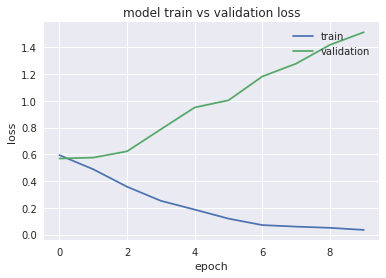

In [36]:
#history = model.fit(X_train, Y_train, epochs=100, validation_data=(X_val, Y_val), shuffle=False)
# plot train and validation loss
plt.plot(LSTM_model.history['loss'])
plt.plot(LSTM_model.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [40]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_test)):
    
    result = model.predict(X_test[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_test[x]):
        if np.argmax(Y_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_test[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 81.3953488372093 %
pos_acc 33.85300668151447 %


# Fit on test data

In [37]:
#test_sequences = tok.texts_to_sequences(X_test)
#test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

prediction = model.predict(X_test)


In [38]:


target_names = ['Bad', 'Good']
print(confusion_matrix(Y_test.argmax(axis=1), prediction.argmax(axis=1)))




[[152 297]
 [224 980]]


### To do
* Test en train bij elkaar voegen en dan later splitsen
* LTSM model aanpassen